In [11]:
#@title Code Library
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pdb
import random
from tqdm import tqdm, tqdm_notebook
def df_handle_outliers(dataset):
  for col in dataset.columns:
    if col!='TimeStamp':
      Q1 = dataset[col].quantile(0.25)
      Q3 = dataset[col].quantile(0.75)
      IQR = Q3 - Q1
      whisker_width = 1.5
      lower_whisker = Q1 -(whisker_width*IQR)
      upper_whisker = Q3 + (whisker_width*IQR)
      dataset[col]=np.where(dataset[col]>upper_whisker,upper_whisker,np.where(dataset[col]<lower_whisker,lower_whisker,dataset[col]))
  return dataset
def add_dataRow(dataset, dataRow, columns):
  temp_df = pd.DataFrame([dataRow], columns= columns)
  dataset = dataset.append(temp_df, ignore_index= True)
  return dataset

def data_overview(dataset, target_variable):
  df = dataset.drop(columns = target_variable)

  columns = ["Observation", "Value"]
  result_dataset = pd.DataFrame(columns=columns)

  result_dataset = add_dataRow(result_dataset, ["Number of rows", df.shape[0]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of columns", df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of numeric variables", df._get_numeric_data().shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of categorical variables", df.select_dtypes(include="category").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of text & id variables", df.select_dtypes(include=object).shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of logical variables", df.select_dtypes(include="bool").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of date variables", df.select_dtypes(include="datetime64").shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["Number of uniform variables", df.loc[:,df.apply(pd.Series.nunique) == 1].shape[1]], columns)

  null_df = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=["null_sum"])
  result_dataset = add_dataRow(result_dataset, ["% of complete case rows",(null_df[null_df["null_sum"] == 0].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (<50%)",(null_df[null_df["null_sum"] <= 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>50%)",(null_df[null_df["null_sum"] > 0.5].shape[0]*100)/df.shape[1]], columns)
  result_dataset = add_dataRow(result_dataset, ["% of row with missing values (>90%)",(null_df[null_df["null_sum"] > 0.9].shape[0]*100)/df.shape[1]], columns)



  return result_dataset

def target_variable_info(dataset, target_variable):
  classes = np.unique(dataset[target_variable])
  
  columns=["Observation","Value"]
  df = pd.DataFrame(columns= columns)

  df = add_dataRow(df, ["Number of classes", len(classes)], columns)
  for xclass in classes:
    value = dataset[dataset[target_variable] == xclass].shape[0]
    df = add_dataRow(df, ["Number of data points in class " + str(xclass), value], columns)

  return df

def df_without_outliers(dataset, col, count=False):
  # pdb.set_trace()
  firstQuantile = dataset[col].quantile(0.25)
  thirdQuantile = dataset[col].quantile(0.75)
  IQR = thirdQuantile - firstQuantile
  leftFence = firstQuantile - (1.5*IQR)
  rightFence = thirdQuantile + (1.5*IQR)
  if count:
    dataset = dataset[(dataset[col] < leftFence) | (dataset[col] > rightFence)]
  else:
    dataset = dataset[(dataset[col] >= leftFence) & (dataset[col] <= rightFence)]

  return dataset

def numerical_overview(dataset, target_variable):
  df = dataset.drop(columns= target_variable)._get_numeric_data()

  columns = ["Variable name", "+ve value count", "-ve value count", "Zero count", \
             "Unique count", "+ve infinity count", "-ve infinity count", \
             "missing %", "Count of outliers"]

  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[df[col] > 0].shape[0])
    dataRow.append(df[df[col] < 0].shape[0])
    dataRow.append(df[df[col] == 0].shape[0])
    dataRow.append(len(df[col].unique()))
    dataRow.append(df[df[col] == np.inf].shape[0])
    dataRow.append(df[df[col] == -np.inf].shape[0])
    dataRow.append((df[col].isnull().sum()*100)/df.shape[0])
    dataRow.append(df_without_outliers(df, col, True).shape[0])

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def categorical_feature_overview(dataset, target_variable):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable).select_dtypes(include="category")

  columns = ["Variable name", "Unique categories", "% missing values"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(len(pd.unique(df[col])))
    dataRow.append(round(((df[col].isnull().sum())*100)/df.shape[0], 3))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def min_text_count(df, col):
  min = -1
  for val in df[col]:
    if not pd.isna(val):
      newMin = len(val.split(" "))
      if min == -1 or min > len(val.split(" ")):
        min = newMin
  
  return min

def max_text_count(df, col):
  max = -1
  for val in df[col]:
    if not pd.isna(val):
      newMax = len(val.split(" "))
      if max == -1 or max < len(val.split(" ")):
        max = newMax
  
  return max

def text_feature_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable).select_dtypes(include=object)

  columns = ["Variable name", "No. of unique words", "Min no. of words in a document", "Max no. of words in a document", "% missing data"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []
    if "id" not in col.lower():
      df[col] = df[col].apply(lambda x : re.sub('\W+',' ', str(x).lower()) if not pd.isna(x) else x)
      # print(df[col])
      dataRow.append(col)
      dataRow.append(len(pd.unique(df[col])))
      dataRow.append(min_text_count(df, col))
      dataRow.append(max_text_count(df, col))
      # print((df[col].isnull()))
      dataRow.append(round((df[col].isnull().sum()*100)/df.shape[0], 2))

      result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def stat_overview(dataset, target_variable):
  df = dataset.drop(columns=target_variable)._get_numeric_data()

  columns = ["Variable name", "Count", "Mean", "Standard deviation", "Variance", \
             "Min", "25th Percentile", "50th Percentile", "75th Percentile", \
             "Max", "10th Percentile", "90th Percentile", "95th Percentile"]
  result_dataset = pd.DataFrame(columns=columns)

  for col in df.columns:
    dataRow = []

    dataRow.append(col)
    dataRow.append(df[col].count())
    dataRow.append(df[col].mean())
    dataRow.append(df[col].std())
    dataRow.append(df[col].var())
    dataRow.append(df[col].min())
    dataRow.append(df[col].quantile(0.25))
    dataRow.append(df[col].quantile(0.50))
    dataRow.append(df[col].quantile(0.75))
    dataRow.append(df[col].max())
    dataRow.append(df[col].quantile(0.10))
    dataRow.append(df[col].quantile(0.90))
    dataRow.append(df[col].quantile(0.95))

    result_dataset = add_dataRow(result_dataset, dataRow, columns)

  return result_dataset

def density_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  fig, axes = plt.subplots(df.shape[1],figsize=(5,df.shape[1]*5))
  for index, col in enumerate(df.columns):
    if "id" not in col:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.distplot(plot_df[col], ax=a)

def box_plot(dataset, target_variable, withOutliers = True):
  # pdb.set_trace()
  df = dataset.drop(columns= target_variable)._get_numeric_data()
  figs, axes = plt.subplots(df.shape[1], figsize = (5, df.shape[1]*5))

  for index, col in enumerate(df.columns):
    if "id" not in col and col != target_variable:
      if not withOutliers:
        plot_df = df_without_outliers(df, col)
      else:
        plot_df = df[col].copy()
        plot_df = pd.DataFrame(plot_df, columns=[col])
      a = None
      if df.columns.shape[0] != 1:
        a = axes[index]
      sns.boxplot(y=plot_df[col], ax=a,orient="v")

def stacked_bar_plot(dataset ,target_variable, top=10):
  # pdb.set_trace()
  data = dataset.select_dtypes(include="category")
  for x_variable in data.columns:

    df = pd.DataFrame(dataset.groupby(x_variable)[target_variable].agg(lambda x : x.eq(1).sum())).reset_index()
    print(df.columns)
    df["total"] = dataset.groupby(x_variable)[target_variable].agg(total="count").reset_index()["total"]
    df.sort_values(by=['total'],inplace=True, ascending=False)

    if df.shape[0] > top:
      df = df[:top]

    ind = np.arange(df.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, df["total"].values)
    p2 = plt.bar(ind, df[target_variable].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(df[x_variable].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [5]:
df = pd.read_excel("..\Datasets\inputdata.xlsx")
df.shape

(30620, 13)

In [6]:
df.head(2)

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18


In [12]:
df=df_handle_outliers(df)

In [15]:
num_overview = numerical_overview(df.loc[:,df.columns[1]:], [])
num_overview.head(num_overview.shape[0])

C:\Users\kagau\AppData\Local\Temp\ipykernel_15460\1285202262.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15460\1285202262.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15460\1285202262.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(temp_df, ignore_index= True)
C:\Users\kagau\AppData\Local\Temp\ipykernel_15460\1285202262.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(t

,Variable name,+ve value count,-ve value count,Zero count,Unique count,+ve infinity count,-ve infinity count,missing %,Count of outliers
0,IE Generation,30620,0,0,28477,0,0,0.0,0
1,IE Demand,30620,0,0,28665,0,0,0.0,0
2,IE Wind Generation,30602,0,18,28849,0,0,0.0,0
3,SNSP,30620,0,0,6776,0,0,0.0,0
4,Hydro Run-of-River,25415,0,5205,2306,0,0,0.0,0
5,Fossil hard coal,23093,0,7527,3342,0,0,0.0,0
6,Fossil oil,27130,0,3490,5484,0,0,0.0,0
7,Fossil peat,29451,0,1169,3301,0,0,0.0,0
8,Fossil gas,30620,0,0,13416,0,0,0.0,0
9,temp,29985,597,38,275,0,0,0.0,0


In [14]:
df['Hydro Run-of-River']= df['Hydro Run-of-River'].interpolate(method='linear')
df['Fossil hard coal']= df['Fossil hard coal'].interpolate(method='linear')
df['Fossil oil']= df['Fossil oil'].interpolate(method='linear')
df['Fossil peat']= df['Fossil peat'].interpolate(method='linear')
df['Fossil gas']= df['Fossil gas'].interpolate(method='linear')
df['ElectricityPrice']= df['ElectricityPrice'].interpolate(method='linear')

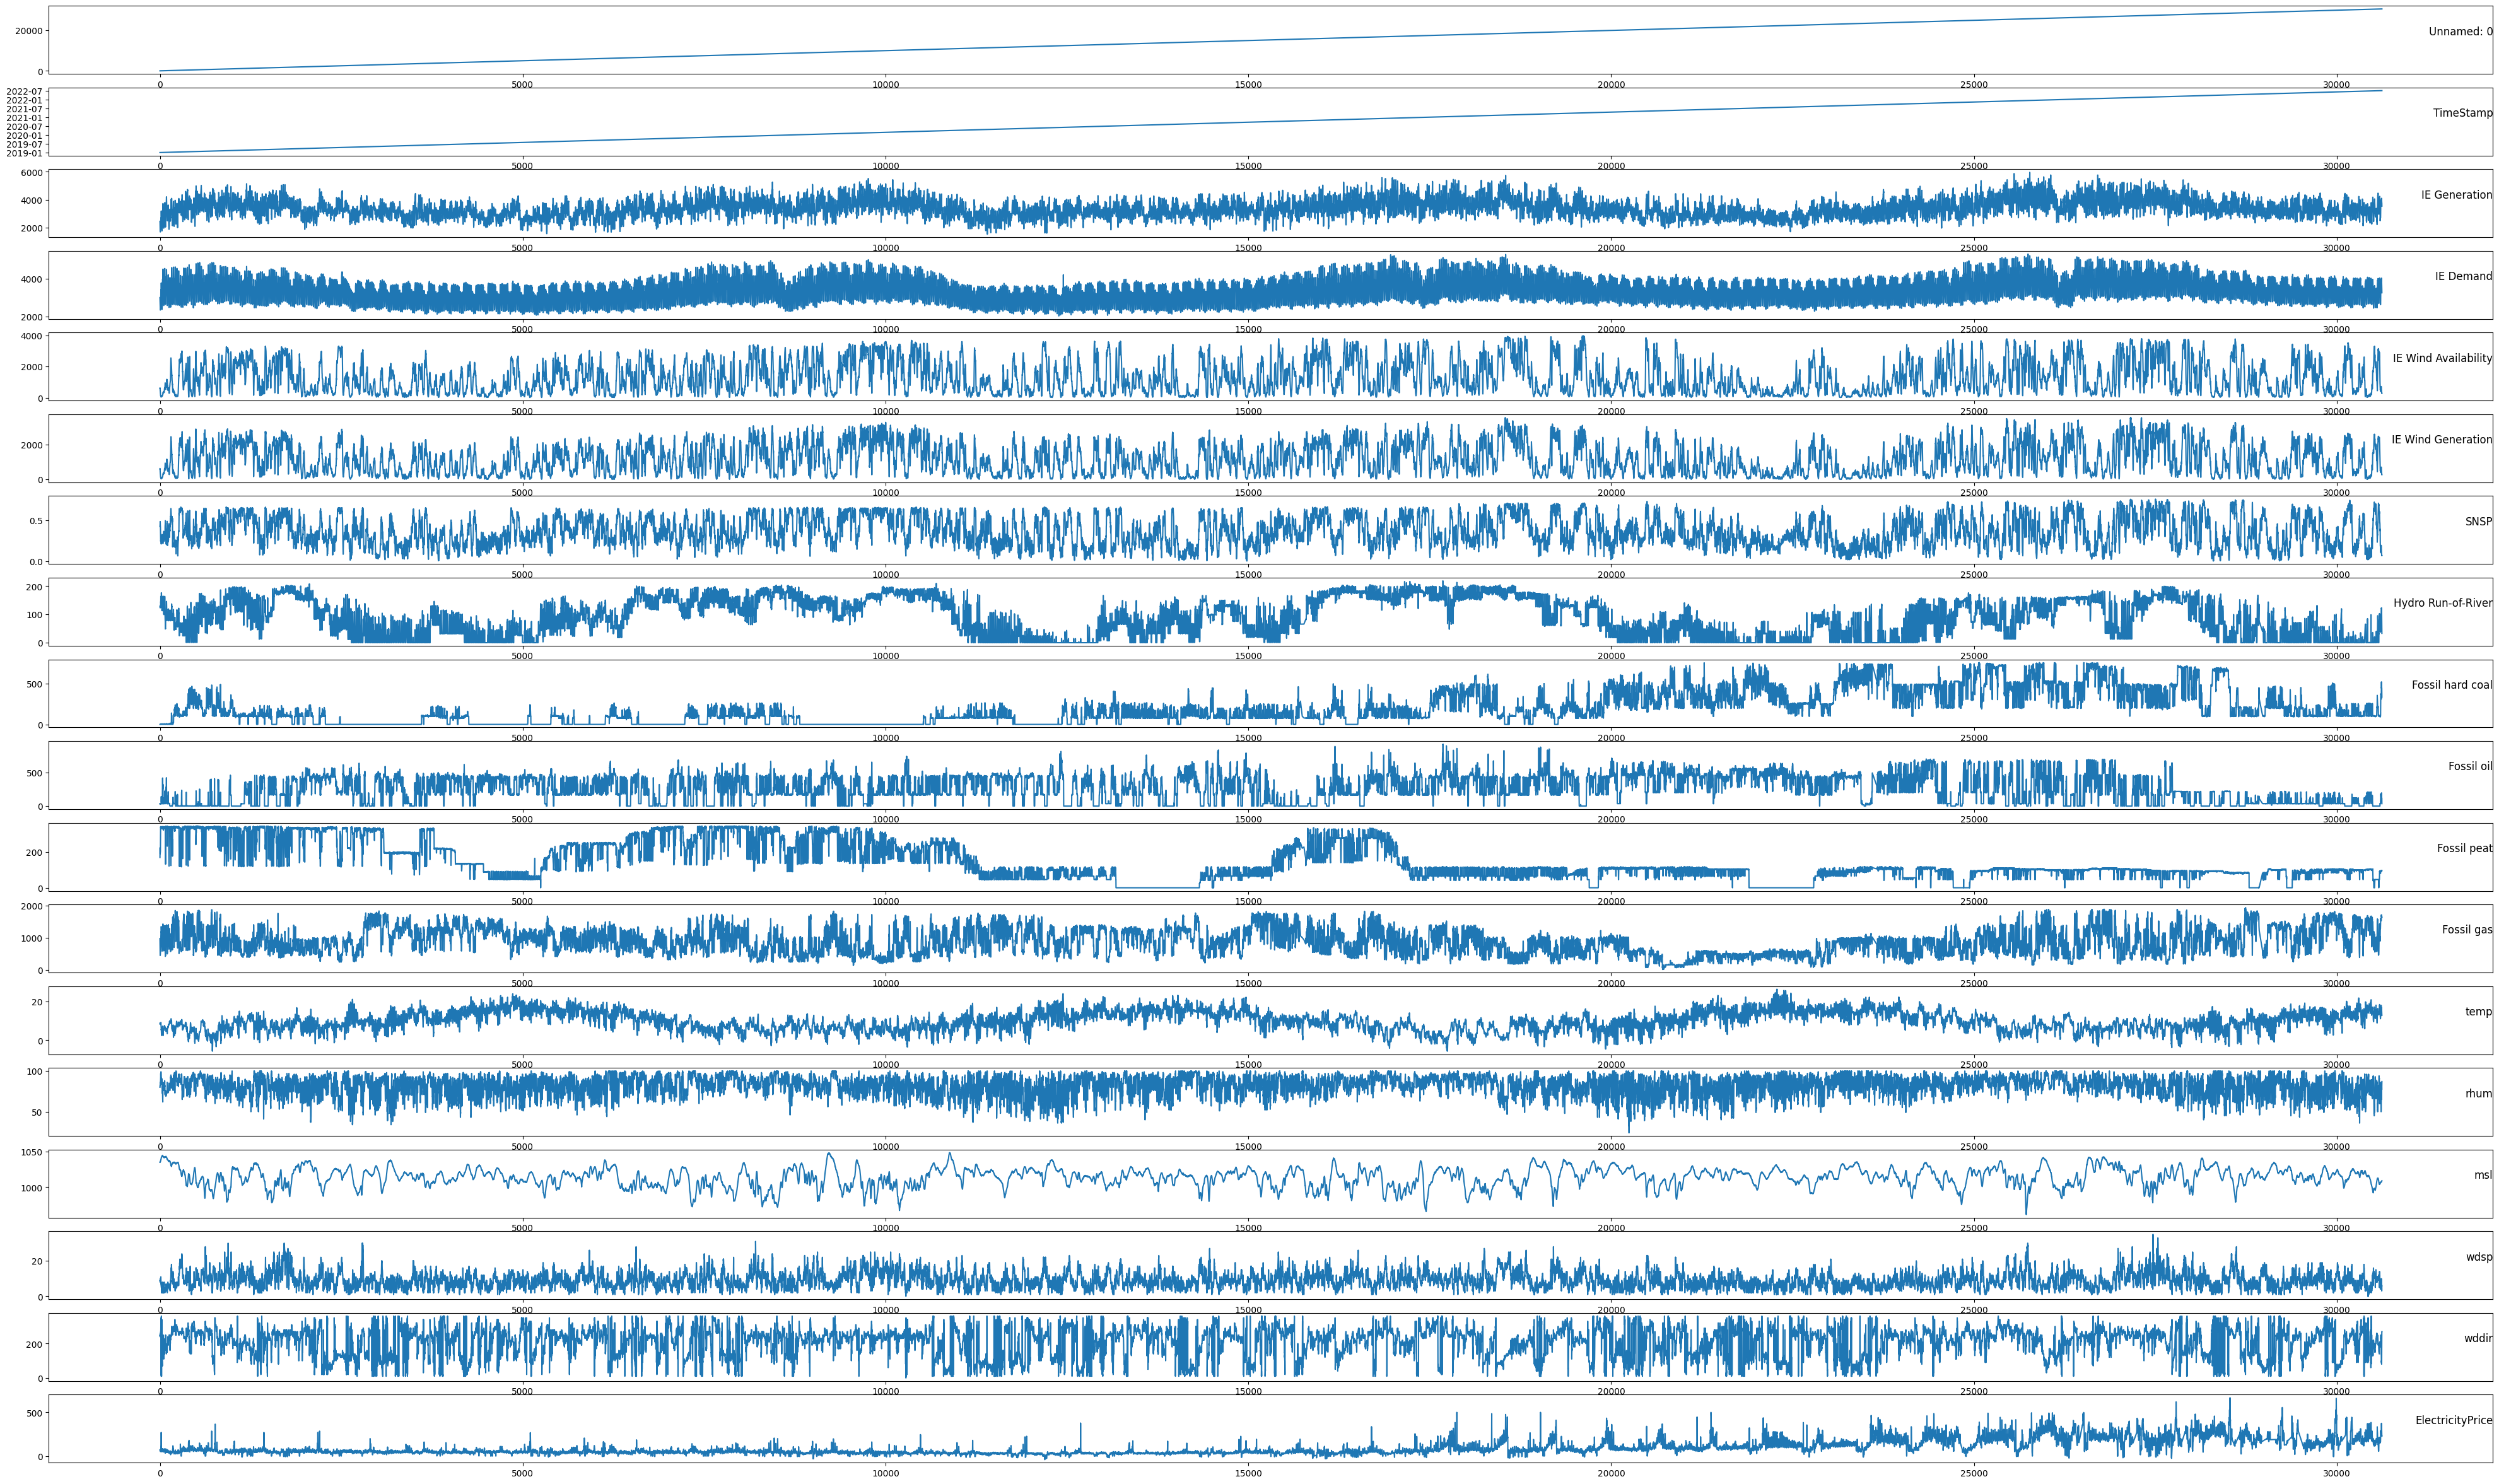

In [17]:
values = df.values
# specify columns to plot
groups = range(0,18)
i = 1
# plot each column
plt.figure()
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(df.columns[group], y=0.5, loc='right')
 i += 1
plt.rc("figure", figsize=(50,30))
plt.show()

In [19]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

df['day'] = df['TimeStamp'].dt.day
df['month'] = df['TimeStamp'].dt.month
df['hour'] = df['TimeStamp'].dt.hour
#df['dayofyear'] = df['TimeStamp'].dt.dayofyear
#df['week'] = df['TimeStamp'].dt.week
df['dayofweek'] = df['TimeStamp'].dt.dayofweek
#df['quarter'] = df['TimeStamp'].dt.quarter
df.head()

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.91,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.16,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.16,1,1,4,1


In [20]:
df.drop_duplicates()

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [21]:
df.shape

(30620, 17)

In [22]:
df = df.set_index('TimeStamp')
df.head(2)

,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
TimeStamp,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1,1,0,1
2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1,1,1,1


In [17]:

df.to_excel("..\\Datasets\\finaldata.xlsx")  

In [23]:
# boxplot for week's count
plt.figure(figsize=(5,3))

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

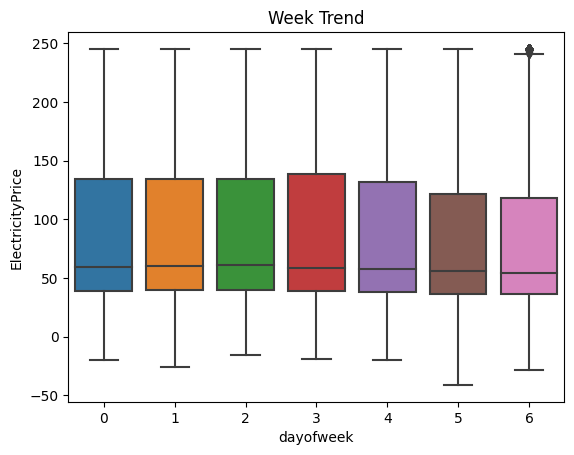

In [25]:
sns.boxplot(x=df['dayofweek'], y=df['ElectricityPrice'], )
plt.title('Week Trend')
plt.show()

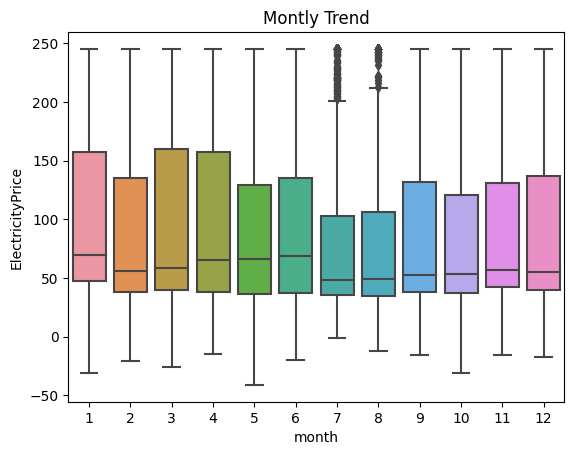

In [26]:
sns.boxplot(x=df['month'], y=df['ElectricityPrice'], )
plt.title('Montly Trend')
plt.show()

In [27]:
from statsmodels.graphics.tsaplots  import plot_acf,plot_pacf
from scipy import fft
from scipy import signal as sig
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection

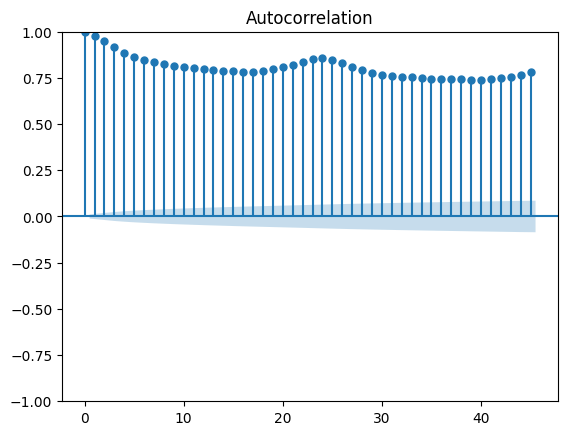

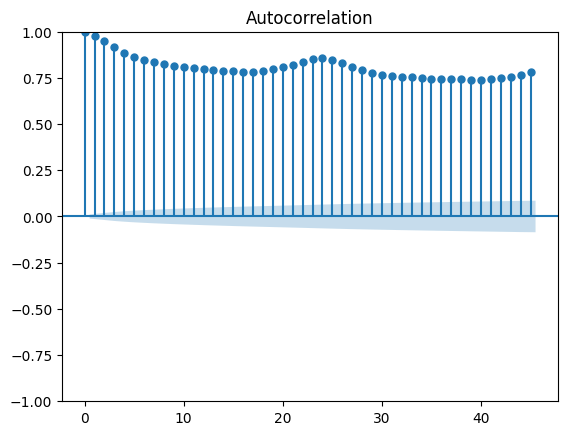

In [28]:
plot_acf(df['ElectricityPrice'])

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


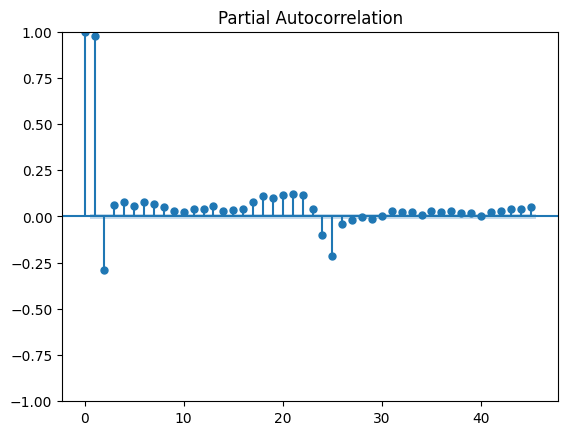

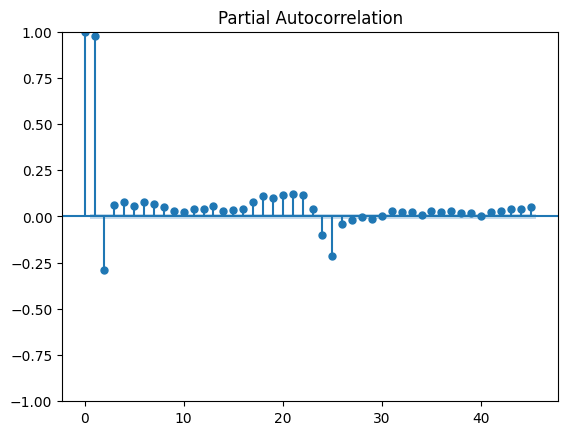

In [29]:
plot_pacf(df['ElectricityPrice'])

In [30]:
result = adfuller(df['ElectricityPrice'])

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -5.866965
p-value: 0.000000


In [31]:
result = adfuller(df['ElectricityPrice'].diff().dropna())

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])
result = adfuller(df['ElectricityPrice'].diff().diff().dropna())

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -31.412892
p-value: 0.000000
ADF Statistic: -51.229631
p-value: 0.000000
